In [1]:
import numpy as np
import tensorflow as tf
import PIL.Image as Image
import tensorflow_hub as hub
import matplotlib.pylab as plt

from tensorflow.keras import layers

In [2]:
from tensorflow.keras.models import load_model 
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

In [3]:
classifier_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 

In [4]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape = IMAGE_SHAPE + (3,))
])

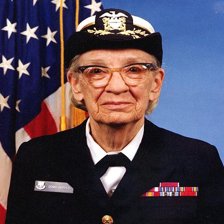

In [5]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [7]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [8]:
# Predict

predicted_class = np.argmax(result[0], axis = -1)
predicted_class

653

In [9]:
# Decode

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


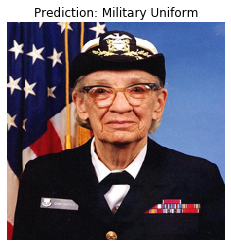

In [10]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [11]:
# Reclassify flowers using tf_hub

data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar = True)

In [12]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size = IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [13]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [14]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [15]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis = -1)]
predicted_class_names

array(['umbrella', 'daisy', "jack-o'-lantern", 'Persian cat', 'daisy',
       'mushroom', 'daisy', 'comic book', 'picket fence', 'bee', 'daisy',
       'flamingo', 'picket fence', 'daisy', 'ant', 'picket fence', 'pot',
       'vase', 'sulphur-crested cockatoo', 'tarantula', 'daisy', 'daisy',
       'cardoon', 'daisy', 'bell pepper', 'daisy', 'bee', 'daisy',
       'barn spider', "jack-o'-lantern", 'rapeseed', 'daisy'],
      dtype='<U30')

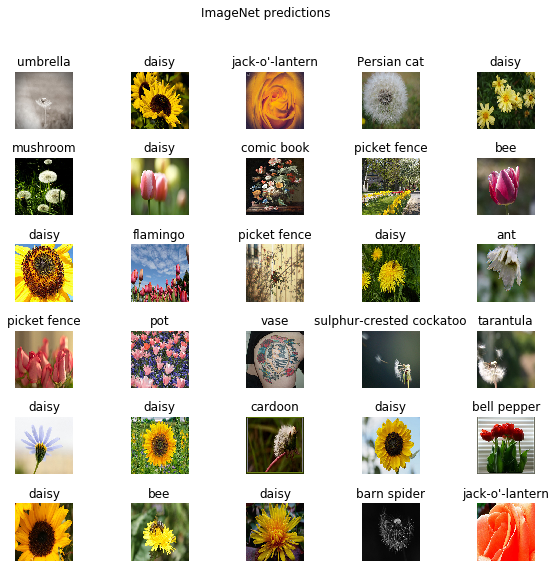

In [16]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace = 0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")